## 1. Read SST Reanalysis
You can download ERSST Reanalysis & Korea station data on below URL : 

URL : https://www.dropbox.com/sh/nbt8zer5r0yex92/AAAVw-MYUggHOBwCWbzUGKrWa?dl=0

In [1]:
## Modules for modulating systems
import os
os.environ['PROJ_LIB'] = '/Users/mb/anaconda3/envs/worklab/share/proj'
import warnings
warnings.filterwarnings('ignore')

## Modules for Calculate netCDF 
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

## 2. Make the Nino3.4 Index

#### <Read SST from ERSST 

In [2]:
## Specify the range of lat, lon and time of SST data
latS = -90.      ;   latN = 90.
lonL = 0.        ;   lonR = 360.
yr_str = 1979    ;   yr_end = 2018

In [5]:
## Open the netCDF4 file
f = xr.open_dataset("C:\\Users\\judyg\\Desktop\\CSL\\sst.ERSST.nc")
var  = f["sst"]

## Read the Coordinates
lat        = f["lat"] 
lon        = f["lon"]
time_year  = f['time'].dt.year # pandas: the year of the datetime

##Indexing(Numpy where function multiple conditions)
ind_year  = np.where((time_year>=yr_str) & (time_year<=yr_end))
ind_lat   = np.where((lat>=latS) & (lat<=latN))
ind_lon   = np.where((lon>=lonL) & (lon<=lonR))

SST = var[ind_year[0],ind_lat[0],ind_lon[0]]
SST_sel = SST.sel(lat=slice(5,-5),lon=slice(190,240))

print(SST_sel.shape)
print(f)

(480, 5, 26)
<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2009)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-05-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_

#### <Make nino3.4 index

In [19]:
## Calcuate the weighted mean of variable
weights_lat      = np.cos(np.deg2rad(lat))
weights_lat.name = "weights"  
SST_index = SST_sel.weighted(weights_lat).mean(("lat","lon"))

## Remove trend of SST_index & Annual mean 
p = SST_index.polyfit(dim="time", deg=1)
fit = xr.polyval(SST_index["time"], p.polyfit_coefficients)
dtrend_SST = SST_index - fit

## Calculate climatology and anomalies of SST_index
#월별로 계산 
clim = dtrend_SST.groupby("time.month").mean()
nino34_SST = dtrend_SST.groupby("time.month") - clim

In [5]:
## DJF nino34index
nino34_SST_season_all = nino34_SST.where(nino34_SST['time.season'] == "DJF")

# Rolling mean -> only Jan(DJF) is not nan
# However, we loose Jan/ Feb in the first year and Dec in the last
nino34_SST_season    = nino34_SST_season_all.rolling(min_periods=3, center=True, time=3).mean()

# Exceptional Case for first year
nino34_SST_season[0] = nino34_SST_season_all[0:2].mean()
nino34_SST_season = nino34_SST_season.groupby('time.year').mean('time')

In [6]:
## Save DJF nino3.4 file
ds = xr.Dataset({'DJFnino34': nino34_SST_season}, coords={'year':nino34_SST_season.year})
ds.to_netcdf("DJF_nino34.nc")

In [7]:
## Save SST anomaly file
p1 = SST.polyfit(dim="time", deg=1)
fit1 = xr.polyval(SST["time"], p.polyfit_coefficients)
d_SST = SST - fit1

clim_SST1 = d_SST.groupby("time.month").mean()
anom_SST1 = d_SST.groupby("time.month") - clim_SST1

ds = xr.Dataset({'anom_SST':anom_SST1}, coords={'time':anom_SST1.time, 'lat':anom_SST1.lat, 
                                               'time.season':anom_SST1['time.season'], 'lon':anom_SST1.lon})
ds.to_netcdf("anom_SST.nc")

## 3. Time-Series of Nino3.4

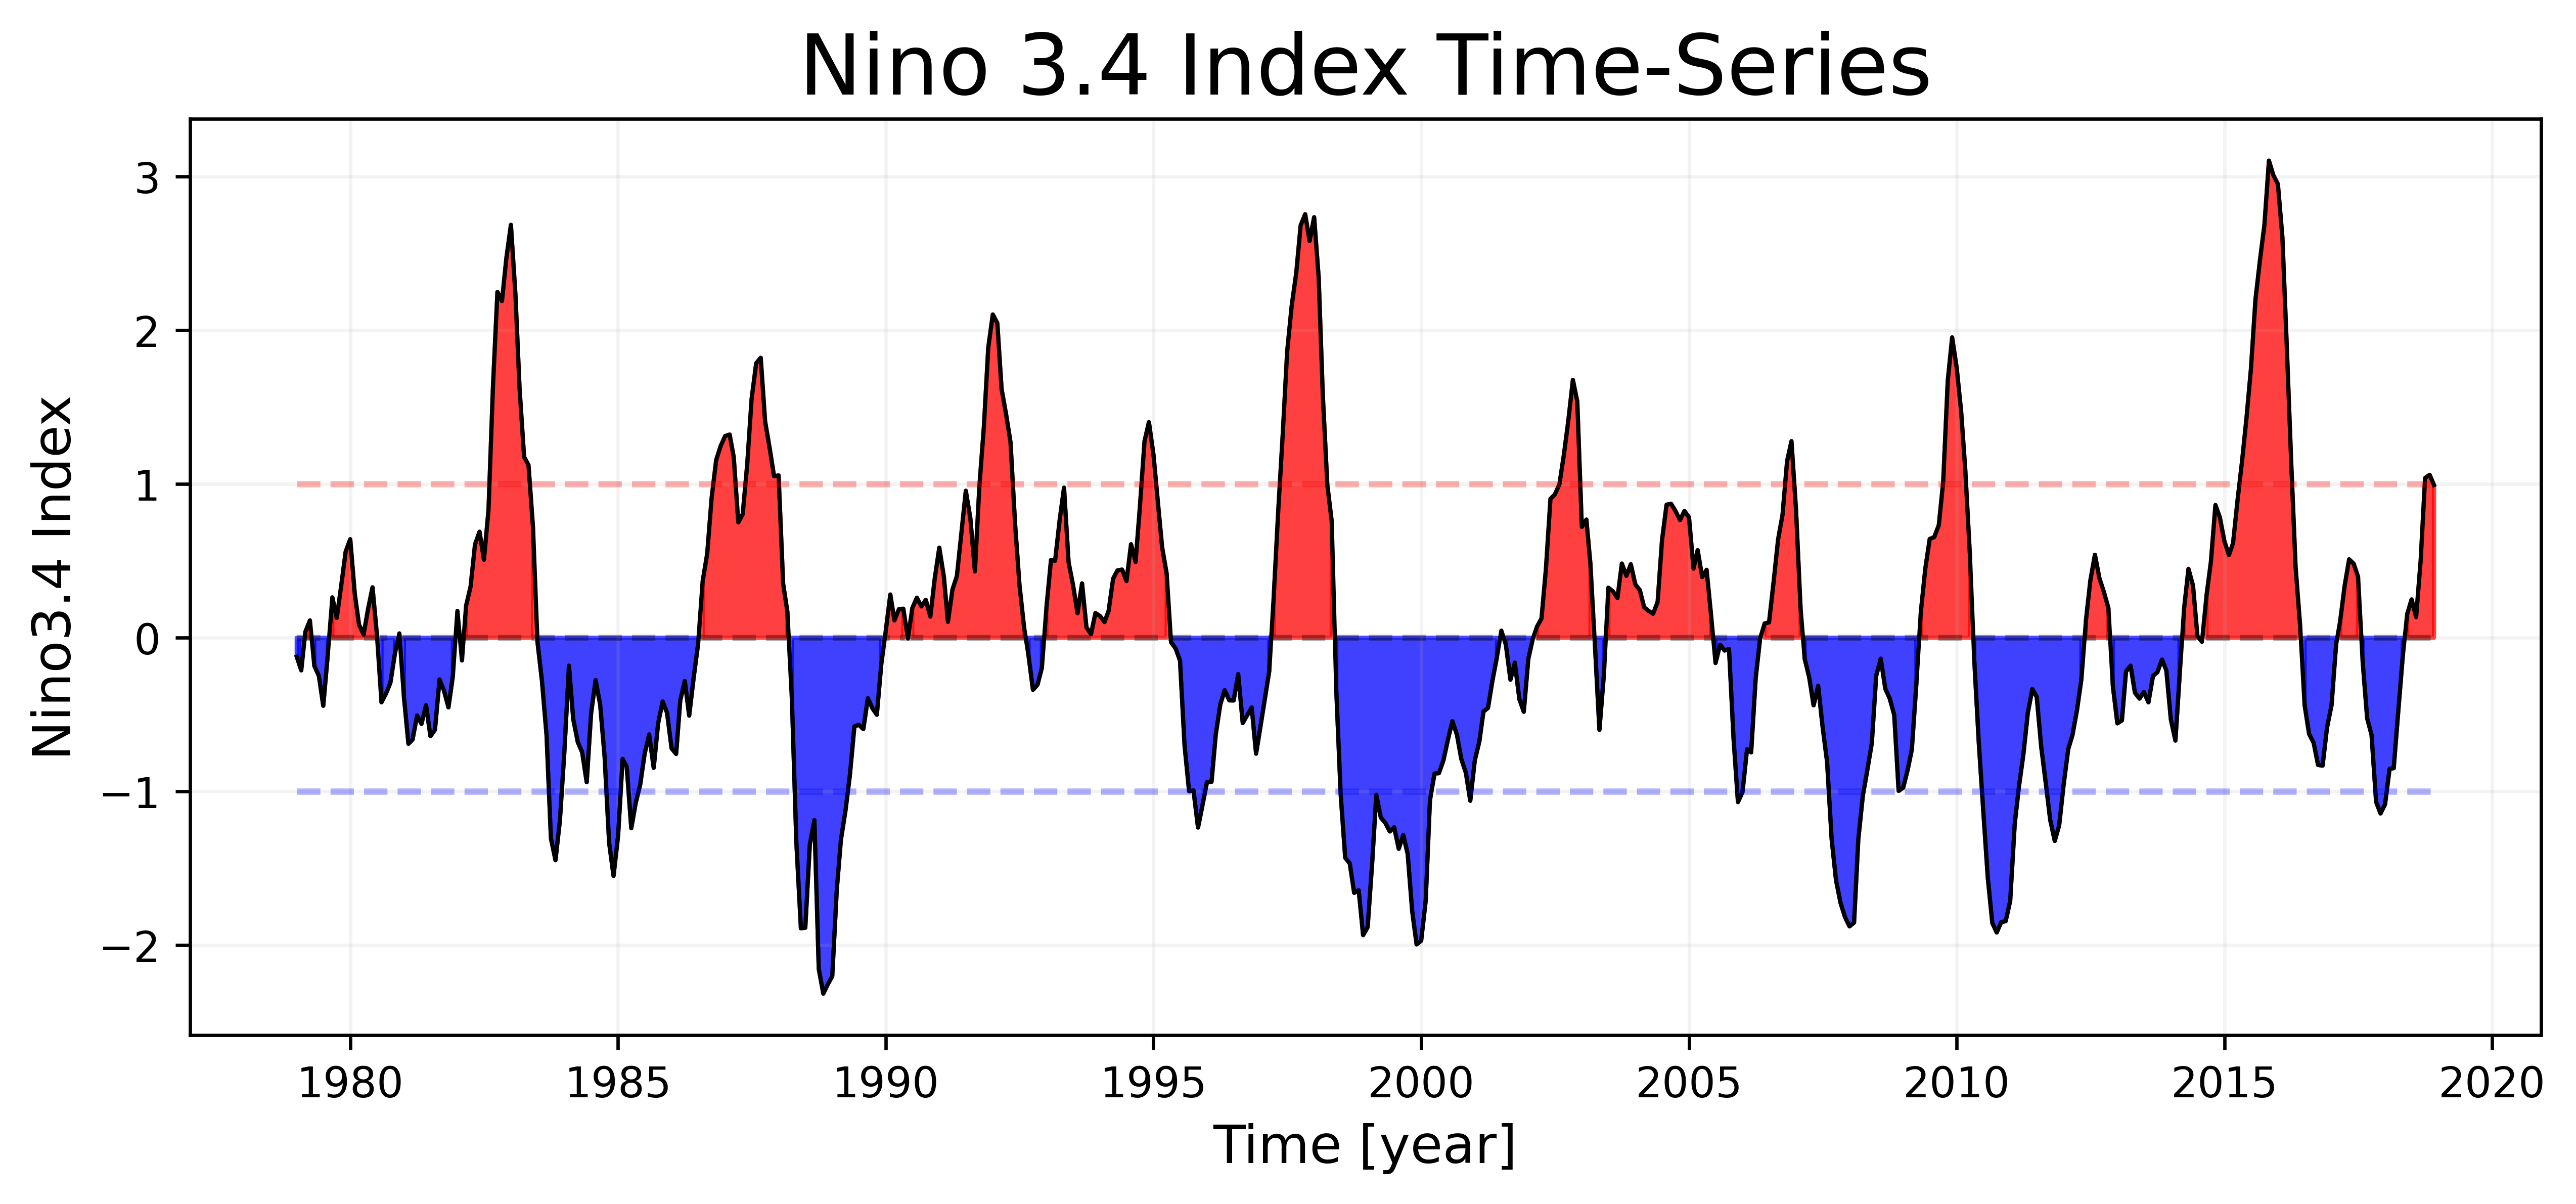

In [8]:
fig, axes = plt.subplots(1,1,figsize=(10,4))
time  = nino34_SST.time.values
index = nino34_SST/nino34_SST.std()  #normalize nino3.4SST 표준편차

## Plot Nino3.4 Time Series & Reference line (1 sigma)
axes.plot(time, index ,linewidth=1,color='k',label='Nino3.4')
axes.plot(time, np.zeros(len(time)),  '--',linewidth=1.5,color='k',alpha=0.3)
axes.plot(time, 1*np.ones(len(time)), '--',linewidth=1.5,color='r',alpha=0.3,label='$1\Sigma$')
axes.plot(time, -1*np.ones(len(time)),'--',linewidth=1.5,color='b',alpha=0.3,label='$-1\Sigma$')

## Fill positive as red and negative as blue
axes.fill_between(time, index, 0, where = (index > 0), color='red', alpha=0.75)
axes.fill_between(time, index, 0, where = (index < 0), color='blue',alpha=0.75)

## Detail plot properties
axes.set_xlabel("Time [year]",fontsize=12.5)
axes.set_ylabel("Nino3.4 Index",fontsize=12.5)
axes.set_title("Nino 3.4 Index Time-Series",fontsize=20)
axes.grid(alpha=0.15)

## <Save Time Series Figure to RESULT directory
dir_name   =  "./"
file_name  =  "TS_Nino34.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## 4. DJF Nino3.4 -Time Series

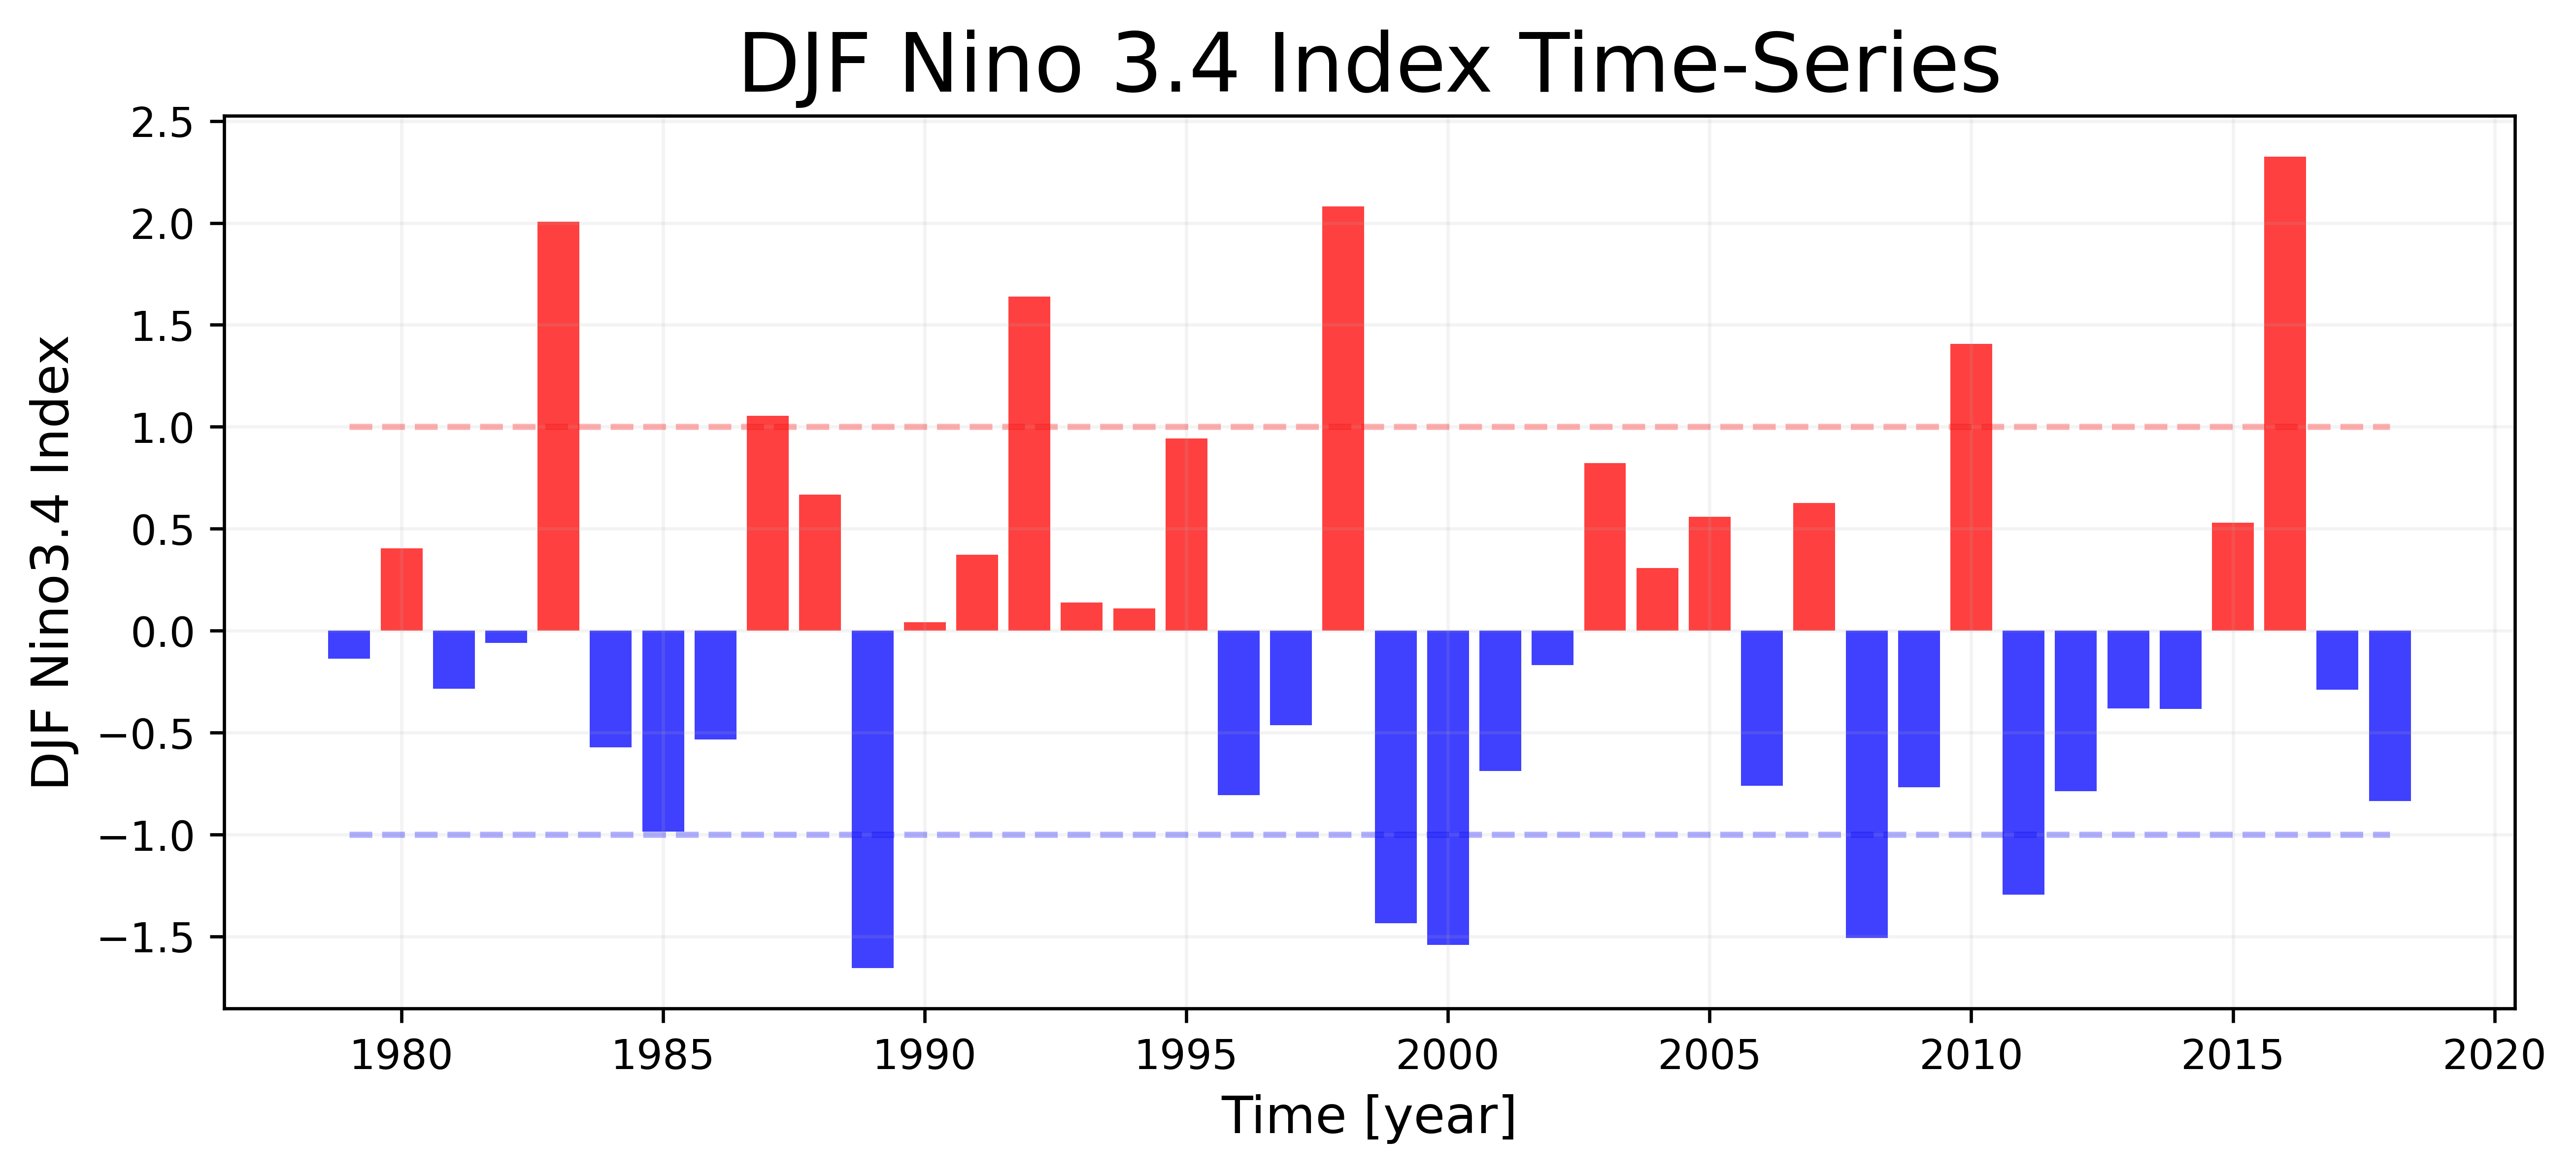

In [9]:
fig, axes = plt.subplots(1,1,figsize=(10,4))
time  = nino34_SST_season.year.values
index = nino34_SST_season/nino34_SST_season.std()  #normalize nino3.4SST 

pos_index = index.copy()
neg_index = index.copy()
pos_index[pos_index <= 0] = np.nan
neg_index[neg_index > 0] = np.nan

axes.bar(time, pos_index ,linewidth=1, color='r', alpha=0.75)
axes.bar(time, neg_index ,linewidth=1, color='b', alpha=0.75)

## Plot Nino3.4 Time Series & Reference line (1 sigma)
axes.plot(time, 1*np.ones(len(time)), '--',linewidth=1.5,color='r',alpha=0.3,label='$1\Sigma$')
axes.plot(time, -1*np.ones(len(time)),'--',linewidth=1.5,color='b',alpha=0.3,label='$-1\Sigma$')

## Detail plot properties
axes.set_xlabel("Time [year]",fontsize=12.5)
axes.set_ylabel("DJF Nino3.4 Index",fontsize=12.5)
axes.set_title("DJF Nino 3.4 Index Time-Series",fontsize=20)
axes.grid(alpha=0.15)

## <Save Time Series Figure to RESULT directory
dir_name   =  "./"
file_name  =  "TS_DJF_Nino34.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)